In [138]:
# CS 328 Team Project
import os
import pandas as pd
import numpy as np
import sys
import librosa
import re
import glob
import csv
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#import plotly.express as px
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

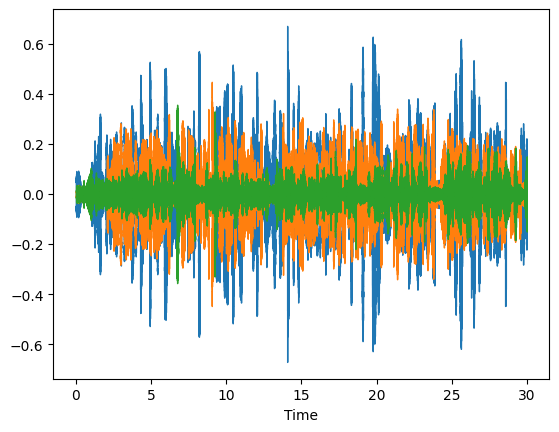

In [139]:
#Load a file
filename = 'Data/sehwa_nc/sehwa_nc.wav' #noise canceling
filename2 = 'Data/sehwa_ns/sehwa headphone ns.wav' # no headphone
filename3 = 'Data/sehwa_no_headphone/sehwa_no_headphone.wav' # headphone without noise


frames = pd.DataFrame()
# duration (in seconds) and offset are used to take care of the no audio in start and the ending of each aud
data, sample_rate = librosa.load(filename, duration=30, offset=0.6)
data2, sample_rate = librosa.load(filename2, duration=30, offset=0.6)
date3, sample_rate = librosa.load(filename3, duration=30, offset=0.6)

librosa.display.waveshow(data, sr=sample_rate)
librosa.display.waveshow(data2, sr=sample_rate)
librosa.display.waveshow(date3, sr=sample_rate)

In [140]:
# # Data Collection
# # List of features
# features = [
#     'meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent',
#     'sfm', 'mode', 'centroid', 'peakf', 'meanfun', 'minfun', 'maxfun',
#     'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'
# ]

# #Data file name is 'Data_collection'
# selected_data = Data_collection[features]

# # Extract summary statistics
# summary_statistics = selected_data.groupby('label').agg(['mean', 'std', 'median', 'quantile', 'min', 'max', 'range'])

# # Display the summary statistics
# print(summary_statistics)

# # Export summary statistics to Excel
# Data_collection = 'data_collection.xlsx'
# summary_statistics.to_excel(Data_collection)

In [141]:
# # extracted features
# extract = ['zero_crossing_rate', 'mfcc', 'spectral_centroid', 'roll_of_frequency']

# # Calculate means for each feature
# means = Data_collection[extract].mean()

# # Display the means
# print("Means for each feature:")
# print(means)

In [142]:
# def extract_features(data):
#  # Extract features
#  zcr = librosa.feature.zero_crossing_rate(y=data)
#  mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
#  rms = librosa.feature.rms(y=data)
#  mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
#  # Average across columns (axis=1)
#  zcr_avg = np.mean(zcr, axis=1)
#  mfcc_avg = np.mean(mfcc, axis=1)
#  rms_avg = np.mean(rms, axis=1)
#  mel_avg = np.mean(mel, axis=1)

#  # Concatenate into single row
#  features = np.concatenate([zcr_avg, mfcc_avg, rms_avg, mel_avg])
#  # Convert to dataframe and transpose it so that the shape is 1x150
#  df = pd.DataFrame(features).T
#  return df



def extract_features(file_path):
    y, sr = librosa.load(file_path)
    amplitude_in_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    avg_db = np.mean(amplitude_in_db)
    print(avg_db)
    return avg_db

In [143]:
# Function to categorize decibel levels into labels
def categorize_volume(avg_db):
    if avg_db > -60:
        return "low volume"
    elif -65 <= avg_db <= -60:
        return "medium volume"
    else:
        return "high volume"

In [144]:
def train_random_forest(frames):
    # Use pandas iloc fn to extract the first 150 columns as features.
    # Careful about how the indexing works (cols start from 0)
    X = frames.iloc[: , 0:150]
    # Use pandas iloc function to extract the 151st column as the prediction target.
    # Again, careful about how indexing works (col numbers start from 0)
    y = frames.iloc[: , 150]
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    Emotion_rf = RandomForestClassifier()
    Emotion_rf_model = Emotion_rf.fit(X_train, y_train)
    Emotion_rf_pred = Emotion_rf_model.predict(X_test)
    print(classification_report(y_test, Emotion_rf_pred))
    # Evaluate on test set
    acc = Emotion_rf_model.score(X_test, y_test)
    Emotion_rf_cm = confusion_matrix(y_test, Emotion_rf_pred)
    print(Emotion_rf_cm)
    
    #Confusion Matrix
    Emotion_rf_cm = confusion_matrix(y_test, Emotion_rf_pred)
    print(Emotion_rf_cm)
    
    return Emotion_rf_model, Emotion_rf_cm, acc

In [145]:
def get_dBFS(data):
    # filename = open(data, 'r')
    # file = csv.DictReader(filename)
    # dBFS = []
    # for col in file:
    #     print(f'col = {col}')
    #     # dBFS.append(float(col[2]))
    file_data = pd.read_csv(data)
    dBFS = file_data['dBFS']
    return dBFS

In [146]:
def train_decision_tree(frames):
    # Extract feature columns 
    X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]

    # Extract target column
    y = frames['activity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=5).fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    return dt_model,dt_cm,acc

In [147]:
# filenames = glob.glob("Data/*/*.wav")
# frames = pd.DataFrame()
# for filename in filenames:

#     # # Load the audio file
#     # y, sr = librosa.load(filename)

#     # # Calculate the amplitude in decibels (dB)
#     # amplitude_in_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

#     # # Display the spectrogram
#     # plt.figure(figsize=(12, 8))
#     # librosa.display.specshow(amplitude_in_db, sr=sr, x_axis='time', y_axis='log')
#     # plt.colorbar(format='%+2.0f dB')
#     # plt.title('Spectrogram')
#     # plt.show()
    

#  emotion = re.search(r'Data/(\w*)/', filename).group(1)
#  # Get the dBFS from the filename
#  # print(f'dBFS: {dBFS}')
#  # duration and offset are used to take care of the no audio in start and the ending of each aud

#  # data, rate= librosa.load(filename, duration=30, offset=0.6)
#  data, rate= librosa.load(filename, duration=30, offset=0.6)
#  feature_df = extract_features(data)
#  emotion_df = pd.DataFrame([emotion])
#  # Assuming feature_df only has one row, you can directly concatenate along the columns
#  combined_df = pd.concat([feature_df, emotion_df], axis=1)
#  frames = frames.append(combined_df, ignore_index=True)

# # Create column names
# col_names = [f'feat_{i}' for i in range(150)] + ['label']
# frames.columns = col_names
# Emotion_rf_model, Emotion_rf_cm, acc = train_random_forest(frames)

In [148]:
data = []
labels = []

# Assuming you have a directory containing your .wav files
directory = glob.glob("Data/*/*.wav")

# Loop through each .wav file in the directory
for filename in directory:
    # window through each audio file at a rate of 10 seconds

    # Extract features (average decibel signal) from the audio file
    avg_db = extract_features(filename)

    # Categorize the volume level
    label = categorize_volume(avg_db)

    # Append the data and label
    data.append(avg_db)
    labels.append(label)

# Convert the lists to NumPy arrays
X = np.array(data).reshape(-1, 1)
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Class Distribution:")
print(pd.Series(y).value_counts())

# Check if the features are within a reasonable range
print("Feature Statistics:")
print(pd.DataFrame(X, columns=['Average Decibel']).describe())

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


-60.93939
-65.00213
-65.663895
-60.352882
-63.895287
-66.87751
-59.298817
-63.538982
-66.82426
               precision    recall  f1-score   support

  high volume       1.00      1.00      1.00         2
medium volume       1.00      1.00      1.00         1

     accuracy                           1.00         3
    macro avg       1.00      1.00      1.00         3
 weighted avg       1.00      1.00      1.00         3

Accuracy: 1.0
Class Distribution:
medium volume    4
high volume      4
low volume       1
Name: count, dtype: int64
Feature Statistics:
       Average Decibel
count         9.000000
mean        -63.599236
std           2.819070
min         -66.877510
25%         -65.663895
50%         -63.895287
75%         -60.939388
max         -59.298817
Confusion Matrix:
[[2 0]
 [0 1]]
